In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')

In [16]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'
#    .assign(grouped_type = lambda d: np.where(d.name.str.startswith('MT-'), 'MT', d.grouped_type))\


count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))
count_df.head()

,id,grouped_type,type,name,IGG_cf_R1_001,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf4_R1_001,Qcf5_R1_001,...,Qcf_Frag2_R1_001,Qcf_HS1_R1_001,Qcf_HS2_R1_001,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001
0,18S_rRNA,rRNA,rDNA,18S_rRNA,900.5,87760,135395.5,36359.5,121554.0,79213.5,...,452256.5,12571.0,28811.0,39625.0,1149.5,826.0,1023.5,1013.5,52462.0,56256.5
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1385.5,192404,272497.5,76302.0,305133.0,199976.5,...,682786.5,22432.0,59323.0,84889.0,7030.0,9547.5,1983.5,2174.5,138076.0,147620.0
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,217.5,83417,76761.0,48814.5,254594.5,192064.0,...,48682.0,15559.0,35226.5,55166.5,192.0,96.0,121.5,159.5,181092.5,193161.0
3,5S_rRNA,rRNA,rDNA,5S_rRNA,4.0,112836,123751.0,36413.5,103664.5,72364.0,...,39846.0,939.5,4702.0,7247.5,133.5,37.5,57.5,85.0,1675.5,1770.5
4,ENSG00000000003.14_2,Protein coding,protein_coding,TSPAN6,0.0,0,0.0,0.0,0.0,1.0,...,9.0,0.0,0.0,0.0,3.0,1.0,8.0,15.0,0.0,0.0


In [17]:
count_df.columns

Index(['id', 'grouped_type', 'type', 'name', 'IGG_cf_R1_001', 'QCF1_R1_001',
       'QCF2_R1_001', 'Qcf10_R1_001', 'Qcf4_R1_001', 'Qcf5_R1_001',
       'Qcf6_SS_R1_001', 'Qcf7_R1_001', 'Qcf8_R1_001', 'Qcf9_R1_001',
       'Qcf_All1_R1_001', 'Qcf_DE1_R1_001', 'Qcf_ED1_R1_001',
       'Qcf_Exo1_R1_001', 'Qcf_Frag1_R1_001', 'Qcf_Frag2_R1_001',
       'Qcf_HS1_R1_001', 'Qcf_HS2_R1_001', 'Qcf_HS3_R1_001', 'Qcf_L1_R1_001',
       'Qcf_L2_R1_001', 'Qcf_NA2_R1_001', 'Qcf_Na1_R1_001', 'S96_cfD_R1_001',
       'S96_cf_R1_001'],
      dtype='object')

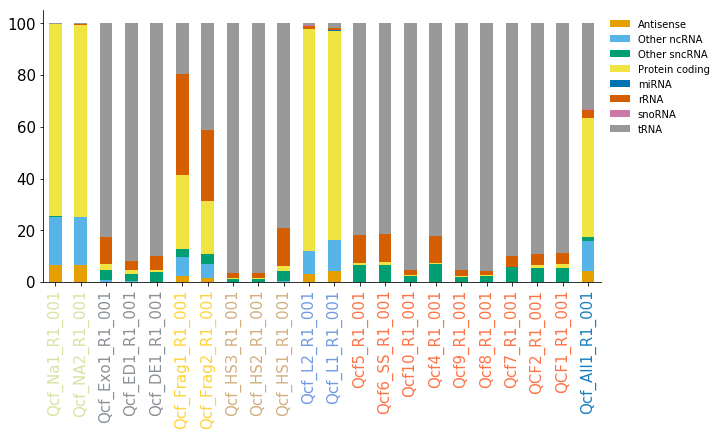

In [18]:
def percentage_columns(d):
    for col in d.columns:
        d[col] = d[col].transform(lambda x: 100*x/x.sum())
    return d

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
bar_df = count_df.drop(['id','type','name'], axis=1)\
    .filter(regex = 'grouped|Q[cC][fF]')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .assign(treatment = lambda d: d.index.map(label_sample))
    
bar_df.sort_values('treatment')\
    .drop('treatment', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)

ce = color_encoder()
ce.fit_transform(bar_df.treatment, simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
sns.despine()

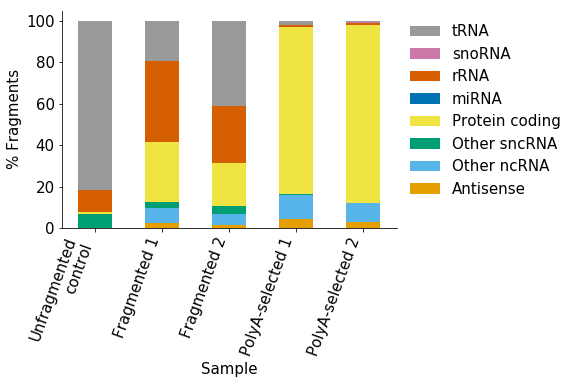

In [42]:
def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS',name):
            treatment = 'Unfragmented\ncontrol'
            is_long = 0
    
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name
        

fig = plt.figure()
ax = fig.add_subplot(111)
count_df\
    .filter(regex = 'grouped|L[12]|Frag|SS')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .rename(columns = rename_longRNA)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1),  fontsize=15)
ax.set_xlabel('Sample')
ax.set_ylabel('% Fragments')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon = False, bbox_to_anchor = (1,1), fontsize = 15)
sns.despine()

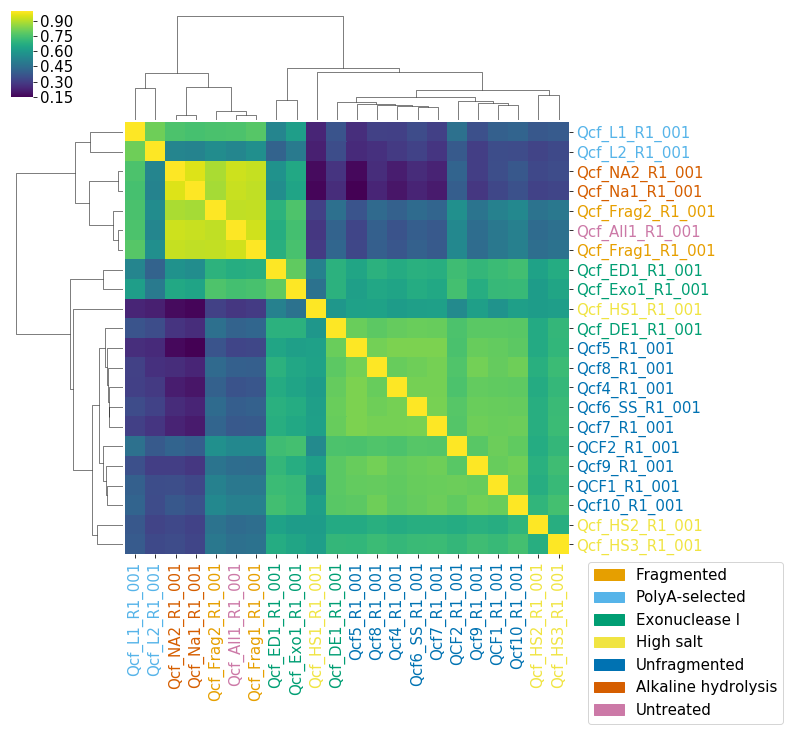

In [20]:
cor_df = np.log(count_df.filter(regex = 'Qcf|QCF')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

In [21]:
def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm

gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])

In [22]:
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr)
expr_df.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [23]:
top_n = 80
tpm_cor_df = tpm_df\
    .filter(regex='id|Qcf')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .iloc[:, 1:]\
    .transform(lambda x: np.log(x+1))\
    .corr(method = 'pearson')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,
bone marrow,bone marrow,0.154946,0.159106,0.528049,0.533427
lymph node,lymph node,0.115042,0.125213,0.475963,0.476473
spleen,spleen,0.124470,0.133258,0.474721,0.475766
appendix,appendix,0.122139,0.133377,0.470467,0.472016
tonsil,tonsil,0.116977,0.129210,0.466182,0.464111
salivary gland,salivary gland,0.172931,0.179142,0.458214,0.471122
colon,colon,0.136913,0.149996,0.448421,0.456559
adipose tissue,adipose tissue,0.136698,0.147533,0.447043,0.448617
urinary bladder,urinary bladder,0.116188,0.128861,0.442469,0.441375


Text(1,0.6,"Spearman's $\\rho$")

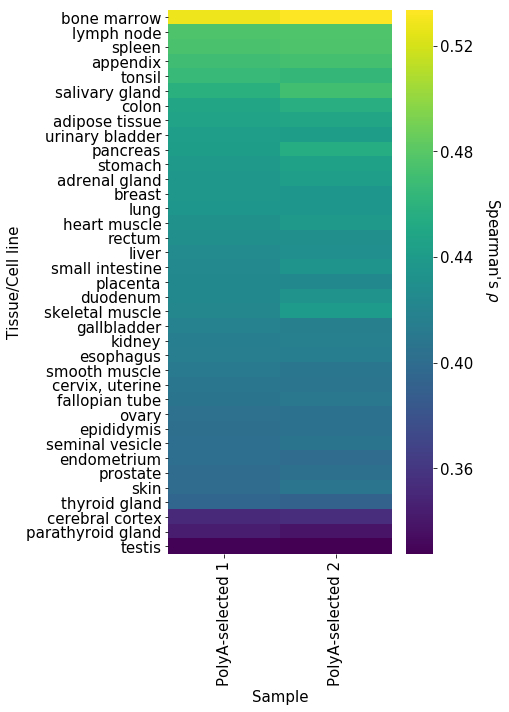

In [24]:
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
           cmap = 'viridis', ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line')
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=15)
fig.text(1,0.6, r"Spearman's $\rho$", rotation = 270, fontsize=15)

Text(0.08,0.85,"Spearman's $\\rho$")

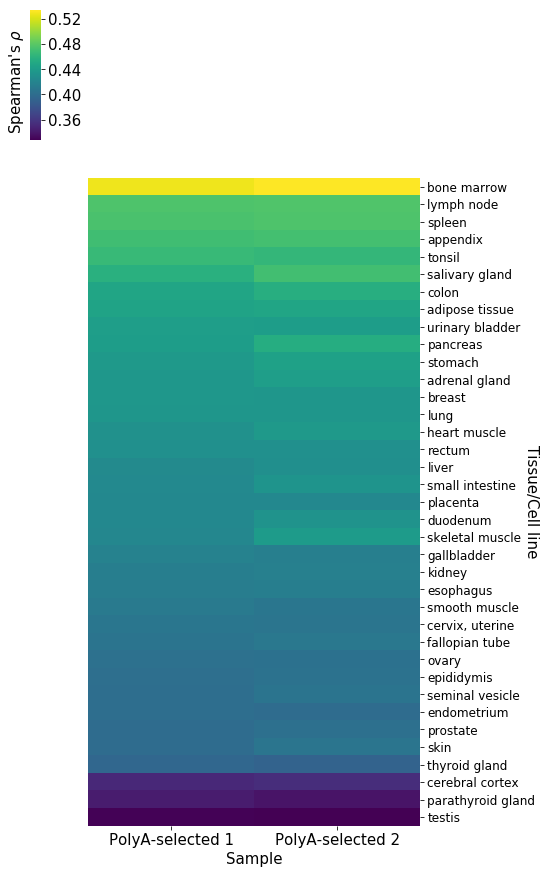

In [25]:
p = sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
                row_cluster=False,
                col_cluster=False,
               cmap = 'viridis',
               figsize = (7,15))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=12)#[p.dendrogram_row.reordered_ind])
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line', rotation=270)
p.fig.text(0.08,0.85, r"Spearman's $\rho$", rotation = 90, fontsize=15)

In [154]:
tpm_df.head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
0,18S_rRNA,rRNA,rDNA,18S_rRNA,795566.0,24968.067815,11415.338098,1091.021658,729.343057,1870
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1338619.0,15360.535758,6400.700364,2483.305223,3138.733674,5034
2,5S_rRNA,rRNA,rDNA,5S_rRNA,81433.5,31150.043639,15654.382932,1978.844099,517.244962,120
3,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.000000,0.000000,0.000000,0.000000,11321
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.120967,0.037478,0.471355,0.146205,11321


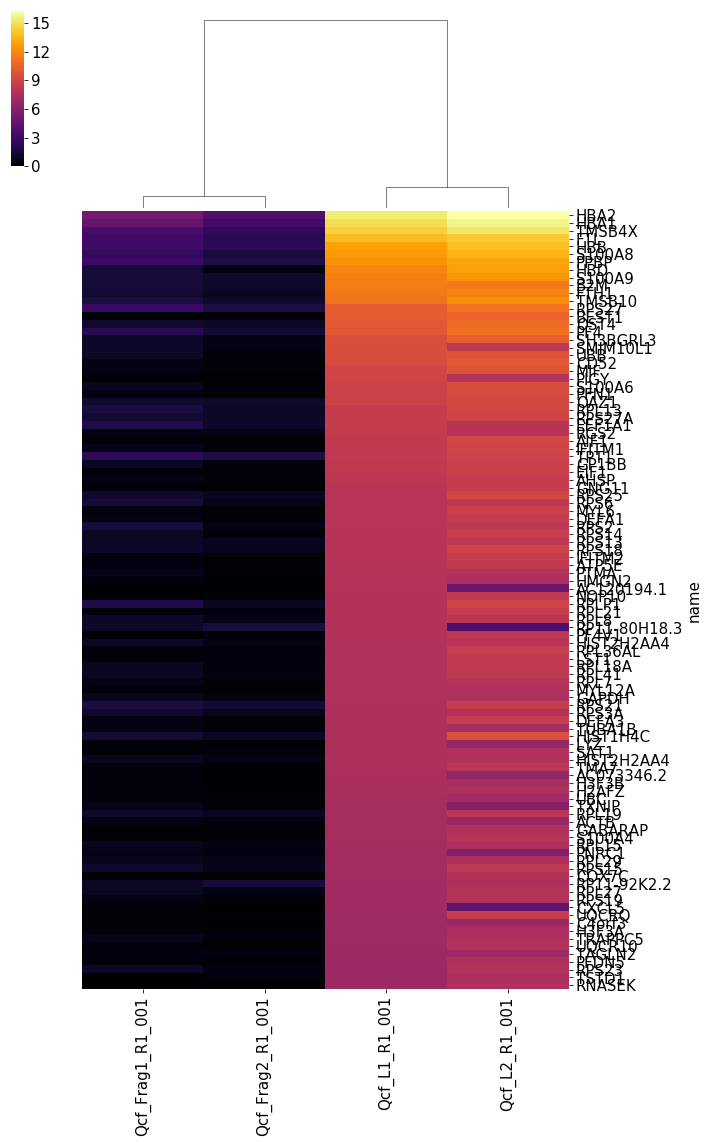

In [26]:
top_n = 100
hd = tpm_df\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .query('type == "protein_coding"')\
    .pipe(lambda d: d[~d.name.str.contains('^MT')])
hd.index = hd.name

p = sns.clustermap(np.log2(hd\
                           .head(top_n)\
                           .filter(regex = 'Q')+1),
              row_cluster=False,
              cmap='inferno',
              figsize = (10,18))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n) +0.5)
yt = ax.set_yticklabels(hd.index[:top_n])

In [27]:
samplename = 'Qcf_L1_R1_001'

tpm_df = count_df\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length) \
    .query('type == "protein_coding"')
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()


rank_df = expr_df\
    .pipe(lambda d: d[np.in1d(d.Sample, ['bone marrow', 'lymph node', 'spleen'])])\
    .rename(columns = {'Gene':'id',
                       'Gene name':'name'})\
    .groupby(['id','name'], as_index=False)\
    .agg({'Value':'mean'})\
    .filter(['id','name','Value'])\
    .merge(hd\
            .loc[:,['id','name',samplename]],
          on = ['id','name']) \
    .assign(rank = lambda d: d[samplename].rank() - d['Value'].rank()) \
    .sort_values('rank', ascending=False)
rank_df.head(20)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


,id,name,Value,Qcf_L1_R1_001,rank
18378,ENSG00000255072,PIGY,0.0,536.964103,17655.5
18692,ENSG00000267697,LUZP6,0.0,70.969381,17516.5
5791,ENSG00000127530,OR7C1,0.0,26.807482,17275.5
17227,ENSG00000206106,KRTAP22-2,0.0,24.443466,17241.5
14249,ENSG00000180934,OR56A1,0.0,21.679298,17194.5
8896,ENSG00000148826,NKX6-2,0.0,21.259409,17186.5
12501,ENSG00000170790,OR10A2,0.0,20.354065,17166.5
18376,ENSG00000255012,OR5M1,0.0,16.958139,17107.5
18569,ENSG00000260836,RP11-152F13.10,0.0,16.049144,17078.5
17602,ENSG00000221836,OR2A5,0.0,14.105716,17013.0


In [28]:
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene', 'Gene name'], values='Value') \
    .reset_index() \
    .pipe(lambda d: d[~d['Gene name'].str.contains('^MT')])\
    .merge(tpm_cor_df.rename(columns=rename_longRNA), on ='Gene', how ='inner') \
    .sort_values('PolyA-selected 1', ascending=False)
cor_df.index= cor_df['Gene name']
cor_df.head(10)

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,37.306697,13.589529,44454.252539,81293.352491
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,25.102251,9.821350,30171.162343,58521.788221
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,11.366360,4.966926,23444.421550,39187.797349
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,8.103972,4.099750,14198.042271,19063.497700
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,8.190201,4.436858,7674.029582,14764.610222
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.846570,2.254472,6364.160868,11748.333446
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,7.739907,3.199983,5365.435700,8198.825642
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.962862,0.465441,3869.676706,7781.880536
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,2.091318,1.358400,3277.442787,5602.733239


Text(0.1,0.85,'TPM ($log_2$)')

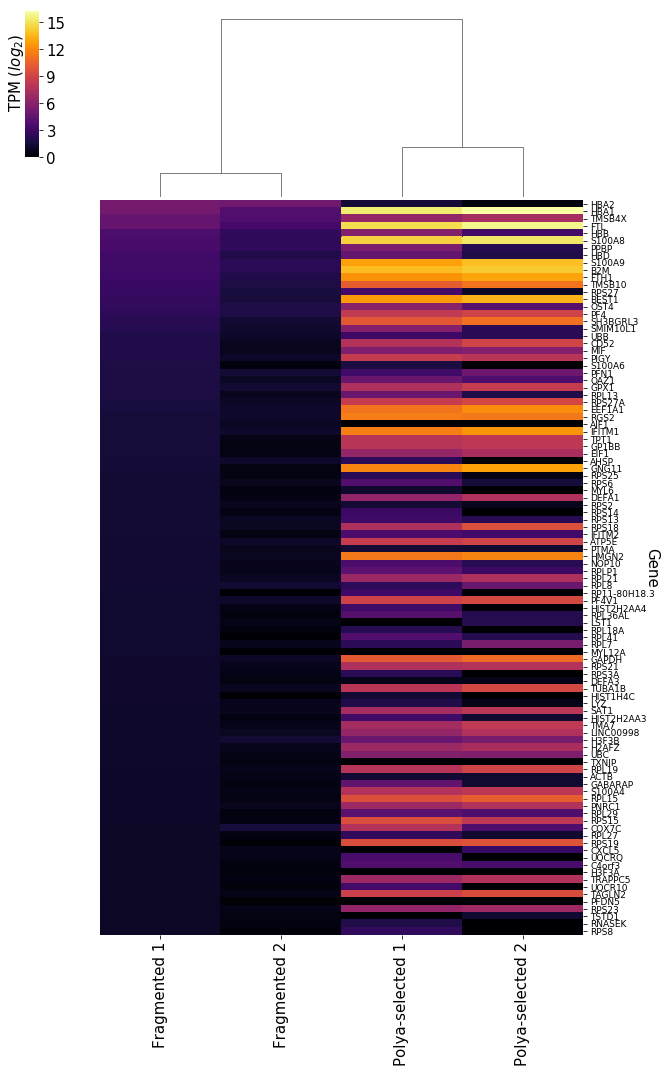

In [29]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.sort_values('Fragmented 1', ascending=False).iloc[:top_n,-4:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n)+0.5)
xt = ax.set_xticks(np.arange(4) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[-4:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

Text(0.1,0.85,'TPM ($log_2$)')

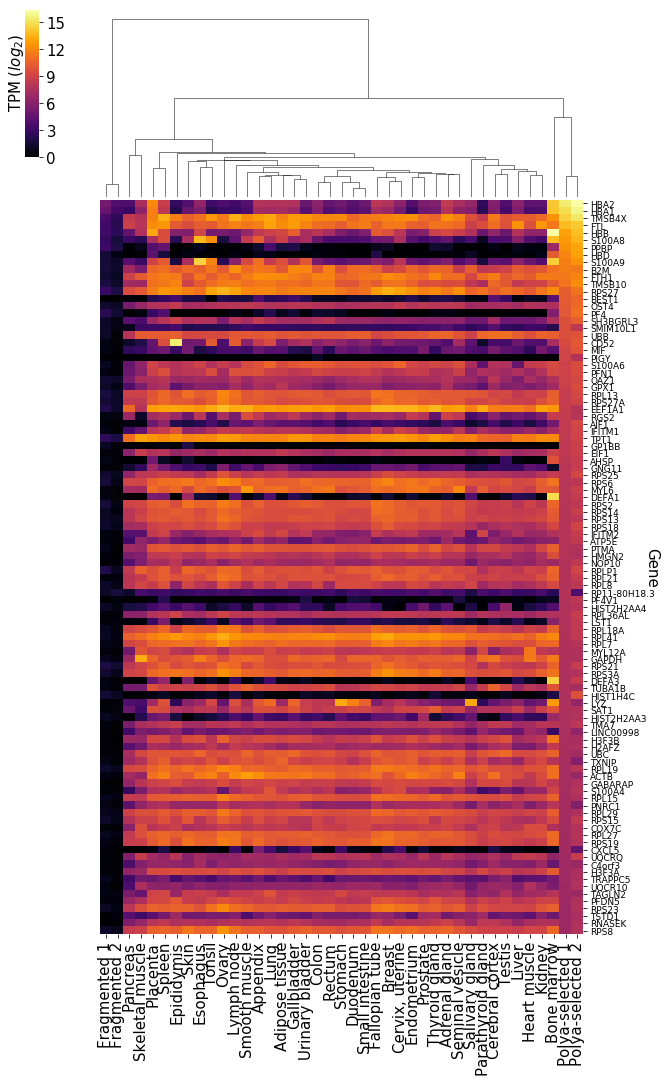

In [30]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,2:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(cor_df.shape[1] - 2) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[2:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

In [31]:
cor_df

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,37.306697,13.589529,44454.252539,81293.352491
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,25.102251,9.821350,30171.162343,58521.788221
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,11.366360,4.966926,23444.421550,39187.797349
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,8.103972,4.099750,14198.042271,19063.497700
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,8.190201,4.436858,7674.029582,14764.610222
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.846570,2.254472,6364.160868,11748.333446
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,7.739907,3.199983,5365.435700,8198.825642
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.962862,0.465441,3869.676706,7781.880536
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,2.091318,1.358400,3277.442787,5602.733239


In [32]:
tpm_df.head()

,id,grouped_type,type,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
3,ENSG00000000003,Protein coding,protein_coding,TSPAN6,26.444522,18.894833,1.113447,0.230170,11321
4,ENSG00000000005,Protein coding,protein_coding,TNMD,10.826582,15.757873,0.278577,0.345522,15083
5,ENSG00000000419,Protein coding,protein_coding,DPM1,13.787346,7.023523,6.385679,1.760048,23688
6,ENSG00000000457,Protein coding,protein_coding,SCYL3,14.633689,10.649521,1.129611,0.233511,44636
7,ENSG00000000460,Protein coding,protein_coding,C1orf112,19.564105,12.504311,5.865714,0.705812,191976


Text(0.9,0.5,'TPM ($log_2$)')

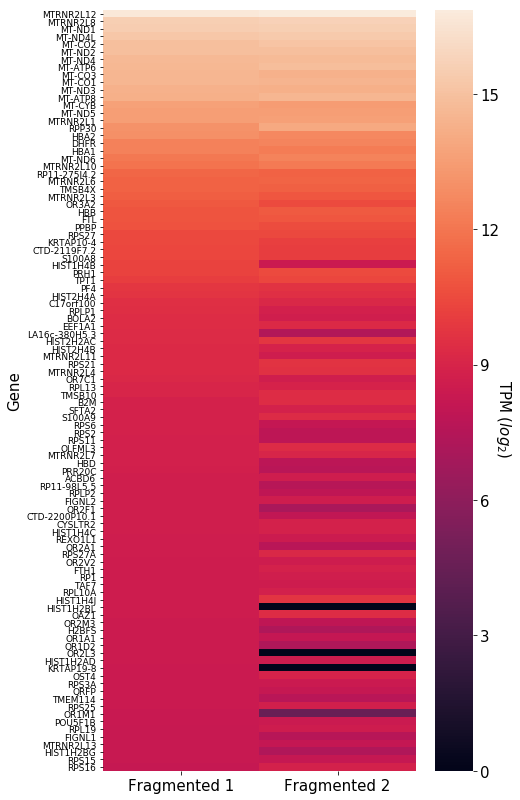

In [33]:
fig = plt.figure(figsize=(7,14))
ax = plt.subplot(111)
frag_df = tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')
p = sns.heatmap(np.log2(frag_df.iloc[:top_n,-2:]+1), ax =ax)
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(2) + 0.5)
xt = ax.set_xticklabels(frag_df.columns[-2:].map(rename_longRNA))
yt = ax.set_yticklabels(frag_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 90)
fig.text(0.9,0.5, r'TPM ($log_2$)', rotation = 270, fontsize=15)

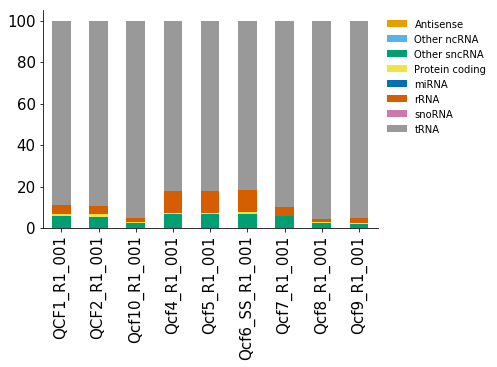

In [34]:
ax = plt.subplot(111)
count_df.filter(regex='grou|Q[cC][Ff][0-9]+')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
sns.despine()

In [35]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
dedup_df.head()

,gene_id,gene_name,gene_type,grouped_type,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,QCF1_R1_001:dedup:antisense,QCF1_R1_001:dedup:sense,QCF2_R1_001:all:antisense,QCF2_R1_001:all:sense,...,Qcf_L2_R1_001:dedup:antisense,Qcf_L2_R1_001:dedup:sense,Qcf_NA2_R1_001:all:antisense,Qcf_NA2_R1_001:all:sense,Qcf_NA2_R1_001:dedup:antisense,Qcf_NA2_R1_001:dedup:sense,Qcf_Na1_R1_001:all:antisense,Qcf_Na1_R1_001:all:sense,Qcf_Na1_R1_001:dedup:antisense,Qcf_Na1_R1_001:dedup:sense
0,18S_rRNA,18S_rRNA,rDNA,rRNA,734,175520,484,85223,918,270791,...,1320,1652,1288,2047,1224,1949,1524,2027,1357,1863
1,28S_rRNA,28S_rRNA,rDNA,rRNA,1089,384807,714,175699,1508,544994,...,18703,19095,2673,3967,2542,3771,3156,4349,2872,3980
2,5.8S_rRNA,5.8S_rRNA,rDNA,rRNA,56,166834,35,12386,89,153522,...,3,192,168,243,153,232,239,319,212,293
3,5S_rRNA,5S_rRNA,rDNA,rRNA,111,225672,58,8135,121,247502,...,1,75,69,115,66,112,129,170,115,157
4,Alu,SINE:AluJb,Repeats,Repeats,281,251,226,189,445,667,...,933,850,35051,33749,33707,32371,44505,50258,41156,46176


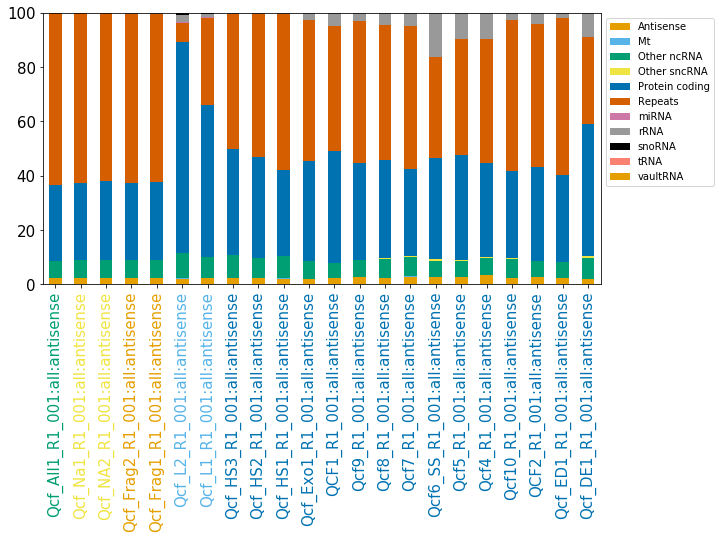

In [36]:
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.viz_tools import color_encoder, simpsons_palette

def label_treatment(x, return_label=False):
    if 'All' in x:
        return 'Total nucleic acid' if return_label else 1
    elif re.search('NA|Na', x):
        return 'Alkaline hydrolysis' if return_label else 2
    elif re.search('Frag|frag', x):
        return 'Fragmented' if return_label else 3
    elif re.search('L[12]', x):
        return 'PolyA-selected' if return_label else 4
    else:
        return 'DNase-treatment' if return_label else 5

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
colors.append('salmon')
dedup_df\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))\
    .filter(regex = 'type|Qcf|QCF')\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .groupby('grouped_type')\
    .sum() \
    .pipe(lambda d: d[d.columns[d.columns.str.contains('anti')]])\
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('dedup')]])\
    .pipe(percentage_columns)\
    .transpose() \
    .assign(prep = lambda d: d.index.map(label_treatment))\
    .sort_values('prep')\
    .drop('prep', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1))

preps = [label_treatment(_.get_text(), return_label=True) for _ in ax.get_xmajorticklabels()]
ce = color_encoder()
ce.fit(preps)
for _, pre in zip(ax.get_xmajorticklabels(),preps):
    _.set_color(ce.encoder[pre])

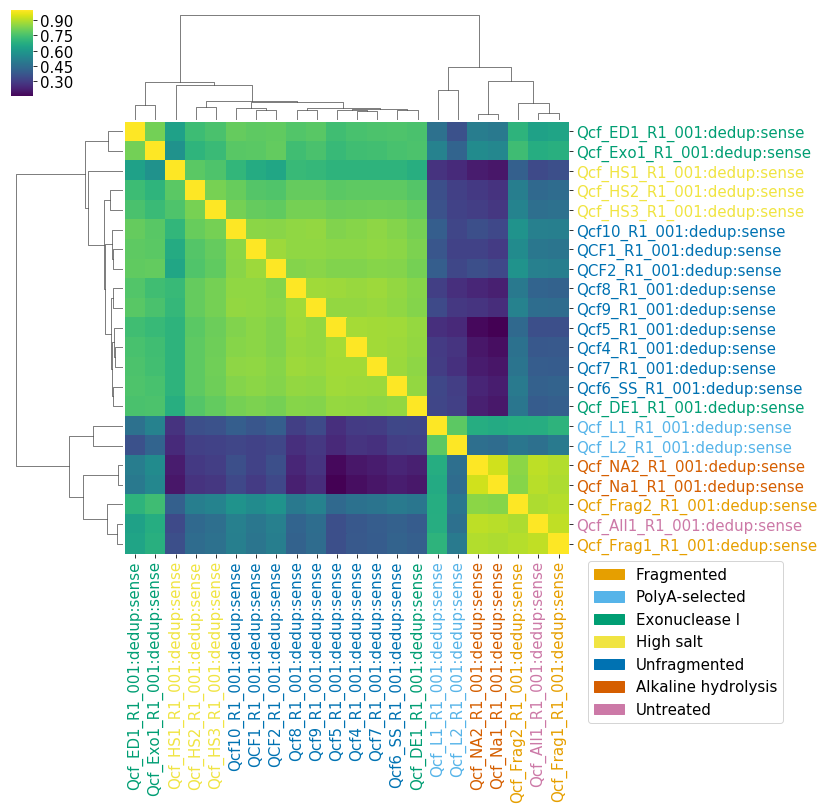

In [40]:
cor_df = np.log(dedup_df.filter(regex = 'Qcf|QCF').filter(regex='dedup:sense')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

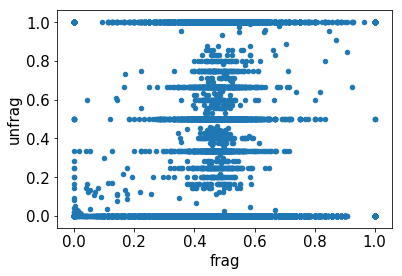

In [38]:
def frac(x, y):
    return x/(x+y)

sense_df = dedup_df\
    .filter(regex = 'Frag1.*dedup|QCF1_.*dedup|type|name|id')  \
    .assign(frag = lambda d: frac(d['Qcf_Frag1_R1_001:dedup:antisense'], d['Qcf_Frag1_R1_001:dedup:sense'])) \
    .assign(unfrag = lambda d: frac(d['QCF1_R1_001:dedup:antisense'],d['QCF1_R1_001:dedup:sense']))  \
    .query('grouped_type != "Repeats"') \
    .replace([np.inf, -np.inf], np.nan)\
    .fillna(0)
sense_df.plot.scatter('frag','unfrag')

In [39]:
sense_df.query('frag > unfrag').sort_values('frag', ascending=False).pipe(lambda d: d[d['QCF1_R1_001:dedup:antisense']>10])

,gene_id,gene_name,gene_type,grouped_type,QCF1_R1_001:dedup:antisense,QCF1_R1_001:dedup:sense,Qcf_Frag1_R1_001:dedup:antisense,Qcf_Frag1_R1_001:dedup:sense,frag,unfrag
12368,ENSG00000167995.15_2,BEST1,protein_coding,Protein coding,11,2,60,6,0.909091,0.846154
29125,ENSG00000230021.9_4,RP11-206L10.17,transcribed_processed_pseudogene,Other ncRNA,101,25,1160,232,0.833333,0.801587
3098,ENSG00000104904.12_4,OAZ1,protein_coding,Protein coding,225,126,188,42,0.817391,0.641026
53089,ENSG00000273734.1_5,LLfos-48D6.2,protein_coding,Protein coding,225,126,209,74,0.738516,0.641026
18051,ENSG00000198727.2,MT-CYB,protein_coding,Protein coding,13,39,235,504,0.317997,0.250000
18092,ENSG00000198804.2,MT-CO1,protein_coding,Protein coding,11,89,201,1210,0.142452,0.110000
2,5.8S_rRNA,5.8S_rRNA,rDNA,rRNA,35,12386,135,42997,0.003130,0.002818


In [168]:
count_df\
    .filter(regex='L[12]|Frag[12]|id|name') \
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .iloc[20:70,:]

,id,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
123808,MT-TE,MT-TE,11018.0,25910.0,395.0,161.0
124196,TRV-CAC10-1,TRV-CAC10-1,10385.0,81093.0,177.0,46.0
123949,TRG-GCC5-1,TRG-GCC5-1,9522.0,51300.0,209.0,36.0
124174,TRU-TCA1-1,TRU-TCA1-1,8686.0,52851.0,362.0,74.0
106518,ENSG00000265150.1,RN7SL2,8621.0,11684.0,24.0,29.0
122431,ENSG00000283029.1_4,RN7SL1,8102.0,10055.0,21.0,32.0
123818,MT-TP,MT-TP,7488.0,11592.0,184.0,62.0
123975,TRIMET-CAT2-1,TRIMET-CAT2-1,6201.0,43632.0,261.0,62.0
59713,ENSG00000228716.6_3,DHFR,5781.0,7503.0,1352.0,2333.0
123942,TRG-CCC8-1,TRG-CCC8-1,5650.0,36168.0,197.0,41.0


In [169]:
tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')

,id,grouped_type,type,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001
name,,,,,
MTRNR2L12,ENSG00000269028,Protein coding,protein_coding,108958.861201,118350.662089
MTRNR2L8,ENSG00000255823,Protein coding,protein_coding,49295.357023,54252.533573
MT-ND1,ENSG00000198888,Protein coding,protein_coding,47885.418981,48247.857909
MT-ND4L,ENSG00000212907,Protein coding,protein_coding,38623.796560,42453.965881
MT-CO2,ENSG00000198712,Protein coding,protein_coding,31340.850839,35480.906697
MT-ND2,ENSG00000198763,Protein coding,protein_coding,30376.759082,30985.647993
MT-ND4,ENSG00000198886,Protein coding,protein_coding,26105.018498,26294.986191
MT-ATP6,ENSG00000198899,Protein coding,protein_coding,25358.179435,30069.090092
MT-CO3,ENSG00000198938,Protein coding,protein_coding,23851.878582,21187.109563
